In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import sys

import momepy
import networkx as nx
from libpysal import weights

%matplotlib inline
import matplotlib.pyplot as plt

parentdir = os.path.dirname(os.getcwd())
sys.path.insert(0, parentdir)
import KeyFunctions as kf

root_path = "D:/GeoData/"
Main_CRS = "EPSG:27700"

In [2]:
#Open a small set of geodata to play with
gdf = kf.load_obj(root_path,"raw_gdf_StPauls")

In [3]:
LReg = gdf.loc[gdf["Type"]=="LReg",:].reset_index(drop=True)
LSOA = gdf.loc[gdf["Type"]=="LSOA",:].reset_index(drop=True)

In [4]:
#Add Sales and Average Cost for each LSOA
LSOA["LReg_Sales"] = [np.count_nonzero(LReg.loc[LReg.within(poly_geom),"Details_Float"].to_numpy()) for poly_geom in LSOA.geometry]
LSOA["LReg_AvCost"] = [np.sum(LReg.loc[LReg.within(poly_geom),"Details_Float"].to_numpy()) for poly_geom in LSOA.geometry]/LSOA["LReg_Sales"]

In [5]:
#Converts a gepandas dataframe of polygones into a networkx network of boundaries
def create_network_from_shapes(shape_gdf):
    
    #Create a weight object from the gdf, this object contains all boundaires between polygons that are next to each other. The convert it to a networkx object
    queen = weights.Queen.from_dataframe(shape_gdf)
    G = queen.to_networkx()

    #Name the nodes in this network the same as the names of the polygon names
    keys = [*range(0,G.number_of_nodes())]
    values = shape_gdf["Name"].to_list()
    Node_names = dict(zip(keys, values))
    G = nx.relabel_nodes(G, Node_names)

    #For plotting on a chart, get the locations of hte polygon centroids for the locations of each node
    centroids = np.column_stack((shape_gdf.centroid.x, shape_gdf.centroid.y))
    positions = dict(zip(G.nodes, centroids))

    return G, positions

#returns a sub network of the nodes within netowork_size edges of your stated node
def witin_n_boundaries(G, node_name, network_size):
    G_n = nx.ego_graph(G, node_name, network_size)
    in_network = list(dict(G_n.nodes()).keys())

    return G_n, in_network

#Given a list of polygons in a given gdf, what is the average value in these polygons
def Average_In_Neighbourhood(shape_gdf, shape_list, count, average):
    new = shape_gdf[shape_gdf['Name'].isin(shape_list)].loc[:,[count, average]]
    sales = np.sum(new[count])
    Av_Cost = np.round(np.sum(new[count] * new[average])/ sales)
    return [sales, Av_Cost]

#Combine the above two finctions into a single function we can use in a list comprehension in the next function
def average_within_n_boundaries_sub(shape_gdf, G, node_name, count, average, network_size):
    G_n, in_network = witin_n_boundaries(G, node_name, network_size=network_size)
    count_mean = Average_In_Neighbourhood(shape_gdf, in_network, count, average)
    return count_mean

#Combine all of the network functions above into a single function.
#For a given set of boundary shapefiles with average and count variables contained within. Find the average value of within network_size boundaries of each polygon
def average_within_n_boundaries(shape_gdf, count, average, network_size):
    G, pos = create_network_from_shapes(shape_gdf)

    count_name = count + "_within_" + str(network_size) + "_boundaries"
    average_name = average + "_within_" + str(network_size) + "_boundaries"
    count_mean = pd.DataFrame([average_within_n_boundaries_sub(shape_gdf, G, x, count, average, network_size) for x in shape_gdf["Name"]], columns = [count_name, average_name])

    return count_mean

c:\Users\richa\Anaconda3\envs\GeoData\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


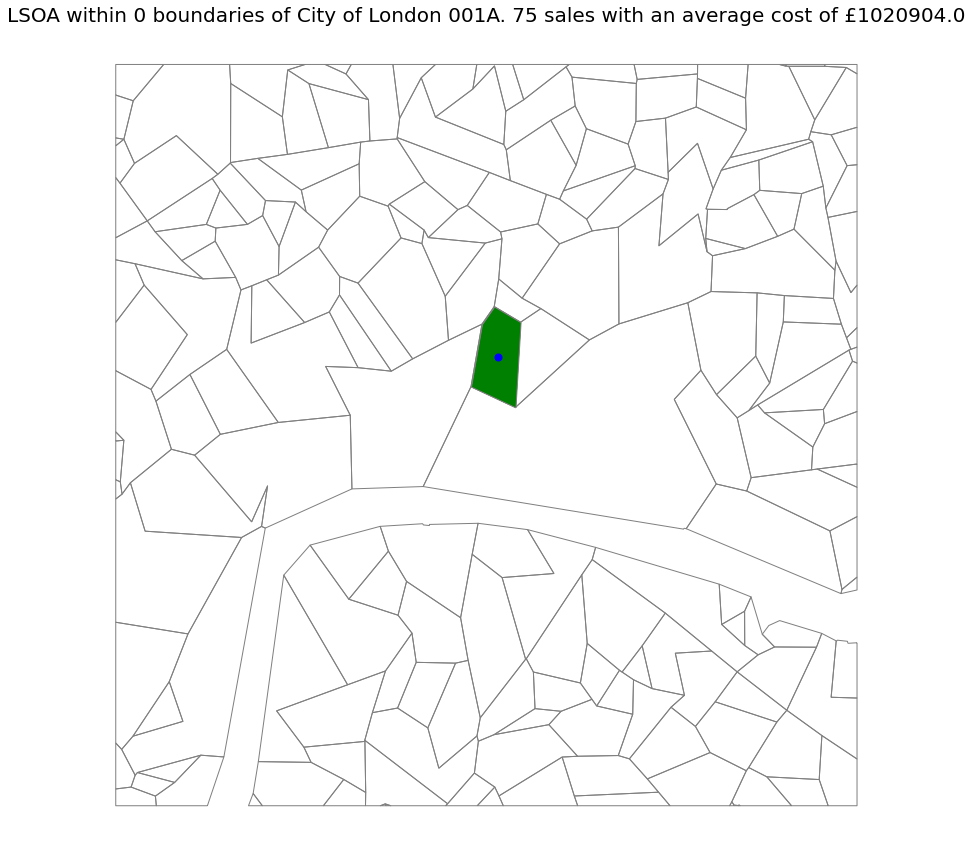

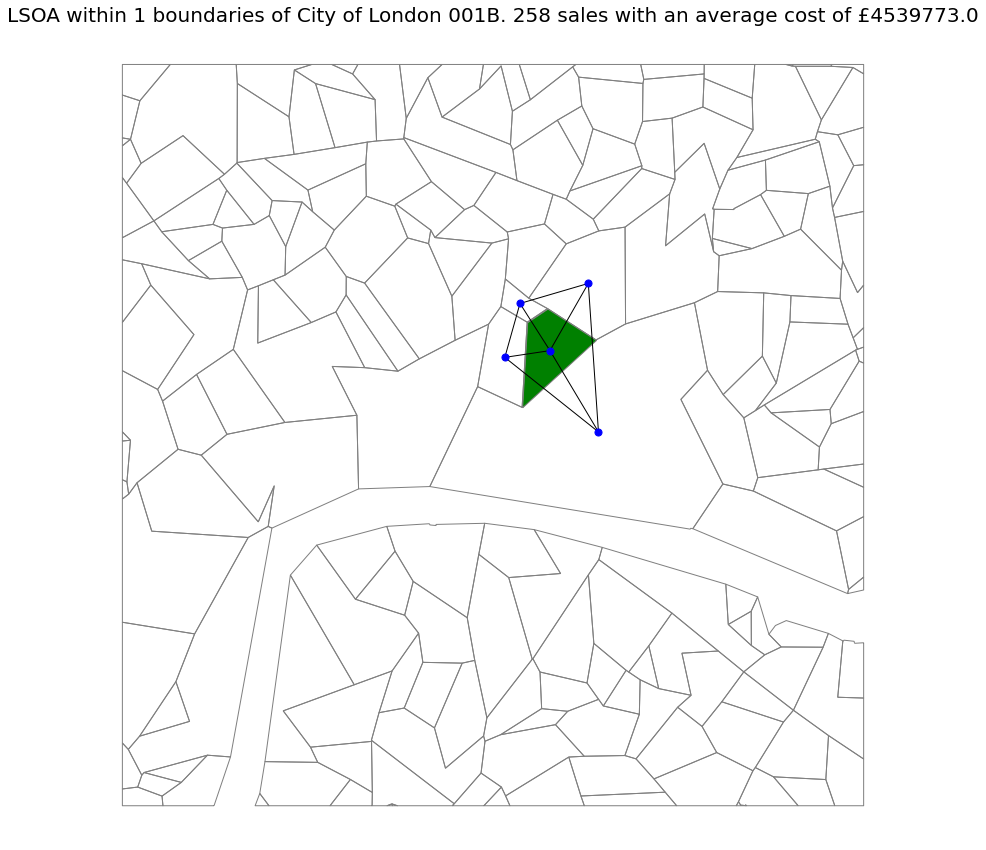

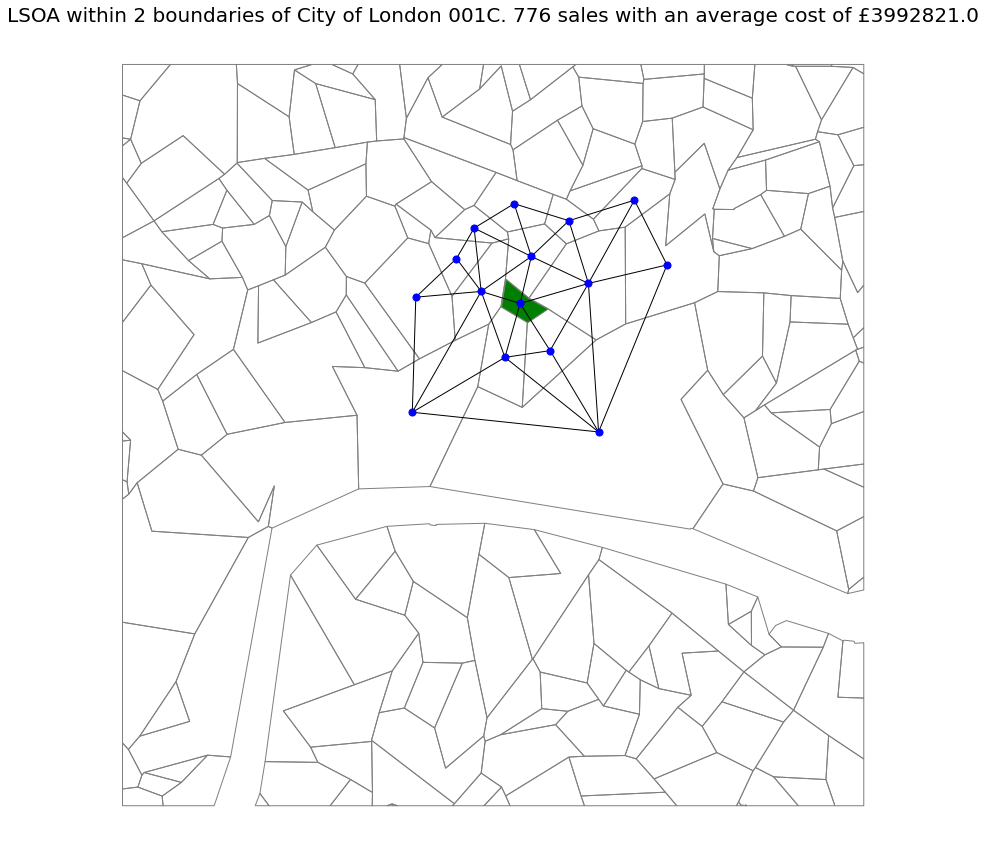

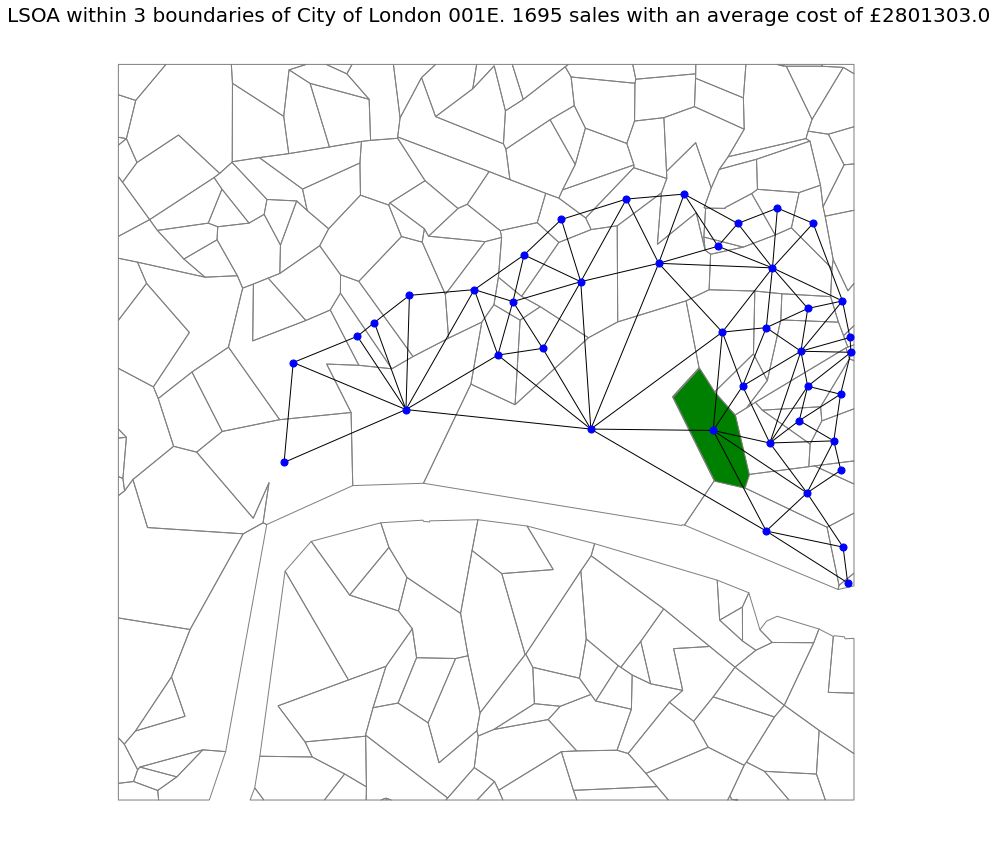

In [12]:
#Test that the outputs are doing expected
network, pos = create_network_from_shapes(LSOA)

for i in range(4):
    subfig = int(i)
    x = LSOA["Name"][i]
    G1, in_G1 = witin_n_boundaries(network, x, i)
    count_mean = Average_In_Neighbourhood(LSOA, in_G1, "LReg_Sales", "LReg_AvCost")
    Sales = count_mean[0]
    avCost = count_mean[1]


    fig, ax = plt.subplots(1,  figsize=(15, 15))
    plt.axis("off")
    plt.title("LSOA within " + str(i) + " boundaries of " + x + ". " + str(Sales) + " sales with an average cost of £" + str(avCost), fontsize=20)
    LSOA.plot(ax=ax, edgecolor='grey', color='none', linewidth=1)
    LSOA.loc[LSOA["Name"]==x,:].plot(ax=ax, edgecolor='grey', color='green', linewidth=1)
    nx.draw(G1, pos, ax=ax, node_color="b", node_size=50)

In [7]:
pd.concat([LSOA, average_within_n_boundaries(LSOA, "LReg_Sales", "LReg_AvCost", 1)], axis=1)

c:\Users\richa\Anaconda3\envs\GeoData\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


,Type,Name,Details_Str,Details_Float,geometry,LReg_Sales,LReg_AvCost,LReg_Sales_within_1_boundaries,LReg_AvCost_within_1_boundaries
0,LSOA,City of London 001A,NaN,NaN,"POLYGON ((532248.250 181332.036, 531948.314 18...",75,1.020904e+06,304,5488346.0
1,LSOA,City of London 001B,NaN,NaN,"POLYGON ((532248.250 181332.036, 532282.629 18...",51,1.753362e+06,258,4539773.0
2,LSOA,City of London 001C,NaN,NaN,"POLYGON ((532419.592 181998.305, 532282.629 18...",15,5.869333e+05,237,3506684.0
3,LSOA,City of London 001E,NaN,NaN,"POLYGON ((533743.689 181261.328, 533837.939 18...",11,6.669737e+06,568,2144312.0
4,LSOA,Camden 026A,NaN,NaN,"POLYGON ((529552.000 181579.418, 529552.000 18...",16,2.542989e+06,108,3792470.0
...,...,...,...,...,...,...,...,...,...
178,LSOA,Hackney 027F,NaN,NaN,"POLYGON ((533533.076 182670.995, 533543.662 18...",47,1.540407e+06,324,1967971.0
179,LSOA,Hackney 027G,NaN,NaN,"POLYGON ((533577.480 182354.766, 533567.188 18...",133,2.821668e+06,412,3929553.0
180,LSOA,Hackney 027H,NaN,NaN,"POLYGON ((532726.570 183211.594, 533007.796 18...",120,5.963035e+05,309,1038310.0
181,LSOA,Hackney 027I,NaN,NaN,"POLYGON ((532545.999 182736.000, 532570.999 18...",49,1.288042e+06,335,1186548.0


In [8]:
pd.concat([LSOA, average_within_n_boundaries(LSOA, "LReg_Sales", "LReg_AvCost", 2)], axis=1)

c:\Users\richa\Anaconda3\envs\GeoData\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


,Type,Name,Details_Str,Details_Float,geometry,LReg_Sales,LReg_AvCost,LReg_Sales_within_2_boundaries,LReg_AvCost_within_2_boundaries
0,LSOA,City of London 001A,NaN,NaN,"POLYGON ((532248.250 181332.036, 531948.314 18...",75,1.020904e+06,993,3987591.0
1,LSOA,City of London 001B,NaN,NaN,"POLYGON ((532248.250 181332.036, 532282.629 18...",51,1.753362e+06,664,3885187.0
2,LSOA,City of London 001C,NaN,NaN,"POLYGON ((532419.592 181998.305, 532282.629 18...",15,5.869333e+05,776,3992821.0
3,LSOA,City of London 001E,NaN,NaN,"POLYGON ((533743.689 181261.328, 533837.939 18...",11,6.669737e+06,1090,2396313.0
4,LSOA,Camden 026A,NaN,NaN,"POLYGON ((529552.000 181579.418, 529552.000 18...",16,2.542989e+06,338,8644978.0
...,...,...,...,...,...,...,...,...,...
178,LSOA,Hackney 027F,NaN,NaN,"POLYGON ((533533.076 182670.995, 533543.662 18...",47,1.540407e+06,807,2376663.0
179,LSOA,Hackney 027G,NaN,NaN,"POLYGON ((533577.480 182354.766, 533567.188 18...",133,2.821668e+06,1027,2509957.0
180,LSOA,Hackney 027H,NaN,NaN,"POLYGON ((532726.570 183211.594, 533007.796 18...",120,5.963035e+05,690,1190787.0
181,LSOA,Hackney 027I,NaN,NaN,"POLYGON ((532545.999 182736.000, 532570.999 18...",49,1.288042e+06,892,1660298.0
